In [1]:
%run "../../../common/0_notebooks_base_setup.py"   

/media/paulati/Nuevo vol/paula/dh/2021/dsad_2021_paula/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
nltk=3.5 already installed
unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


<img src='../../../common/logo_DH.png' align='left' width=35%/>

# Series de Tiempo - Práctica independiente


#### En esta práctica independiente vas a poner en práctica tu conocimiento de series de tiempo. 

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')


En este caso, nuestra variable de interés en la cantidad de pasajeros de una compañía aérea.

Aplicá lo que aprendiste en la clase de series de tiempo y desarrolla un modelo para esta serie de tiempo.

In [3]:
df = pd.read_csv('../Data/AirPassengers.csv')
df.shape

(144, 2)

In [4]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.dtypes

Month          object
#Passengers     int64
dtype: object

In [6]:
df.rename(columns={'#Passengers':'Passengers', 'Month':'Date'}, inplace=True)

df.head()

,Date,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [7]:
df['Date'] = pd.to_datetime(df['Date'])

df['Date'].dtype

dtype('<M8[ns]')

In [8]:
df = df.sort_values(by = "Date")

In [9]:
df['Month'] = pd.DatetimeIndex(df['Date']).month
df.head()

,Date,Passengers,Month
0,1949-01-01,112,1
1,1949-02-01,118,2
2,1949-03-01,132,3
3,1949-04-01,129,4
4,1949-05-01,121,5


In [10]:
df.index = pd.PeriodIndex(df.Date, freq='M')
df.head()

,Date,Passengers,Month
Date,,,
1949-01,1949-01-01,112,1
1949-02,1949-02-01,118,2
1949-03,1949-03-01,132,3
1949-04,1949-04-01,129,4
1949-05,1949-05-01,121,5


Vamos a definir una función que plotea series de tiempo:

In [11]:
# Función que plotea la serie:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

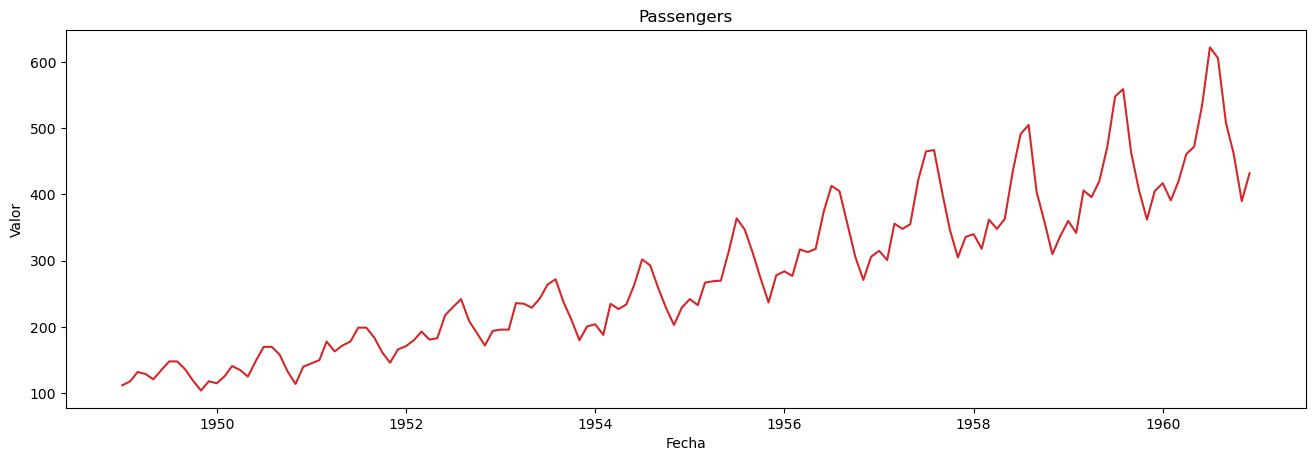

In [12]:
plot_df(df, x=df.Date, y=df.Passengers, title="Passengers")

In [13]:
df["timeIndex"] = pd.Series(np.arange(len(df['Passengers'])), index=df.index)
df.head()

,Date,Passengers,Month,timeIndex
Date,,,,
1949-01,1949-01-01,112,1,0
1949-02,1949-02-01,118,2,1
1949-03,1949-03-01,132,3,2
1949-04,1949-04-01,129,4,3
1949-05,1949-05-01,121,5,4


In [14]:
df.tail()

,Date,Passengers,Month,timeIndex
Date,,,,
1960-08,1960-08-01,606,8,139
1960-09,1960-09-01,508,9,140
1960-10,1960-10-01,461,10,141
1960-11,1960-11-01,390,11,142
1960-12,1960-12-01,432,12,143


In [15]:
dummies_mes = pd.get_dummies(df['Month'], drop_first=True, prefix='Month')
df = df.join(dummies_mes)
df.sample(10)

,Date,Passengers,Month,timeIndex,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,
1957-08,1957-08-01,467,8,103,0,0,0,0,0,0,1,0,0,0,0
1959-10,1959-10-01,407,10,129,0,0,0,0,0,0,0,0,1,0,0
1950-06,1950-06-01,149,6,17,0,0,0,0,1,0,0,0,0,0,0
1960-11,1960-11-01,390,11,142,0,0,0,0,0,0,0,0,0,1,0
1960-02,1960-02-01,391,2,133,1,0,0,0,0,0,0,0,0,0,0
1960-12,1960-12-01,432,12,143,0,0,0,0,0,0,0,0,0,0,1
1952-07,1952-07-01,230,7,42,0,0,0,0,0,1,0,0,0,0,0
1951-03,1951-03-01,178,3,26,0,1,0,0,0,0,0,0,0,0,0
1956-10,1956-10-01,306,10,93,0,0,0,0,0,0,0,0,1,0,0


In [16]:
df_train, df_test = train_test_split(df, test_size=12, random_state=42, shuffle=False)

In [17]:
df_train.tail()

,Date,Passengers,Month,timeIndex,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,
1959-08,1959-08-01,559,8,127,0,0,0,0,0,0,1,0,0,0,0
1959-09,1959-09-01,463,9,128,0,0,0,0,0,0,0,1,0,0,0
1959-10,1959-10-01,407,10,129,0,0,0,0,0,0,0,0,1,0,0
1959-11,1959-11-01,362,11,130,0,0,0,0,0,0,0,0,0,1,0
1959-12,1959-12-01,405,12,131,0,0,0,0,0,0,0,0,0,0,1


In [18]:
df_test.head()

,Date,Passengers,Month,timeIndex,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,
1960-01,1960-01-01,417,1,132,0,0,0,0,0,0,0,0,0,0,0
1960-02,1960-02-01,391,2,133,1,0,0,0,0,0,0,0,0,0,0
1960-03,1960-03-01,419,3,134,0,1,0,0,0,0,0,0,0,0,0
1960-04,1960-04-01,461,4,135,0,0,1,0,0,0,0,0,0,0,0
1960-05,1960-05-01,472,5,136,0,0,0,1,0,0,0,0,0,0,0


Creá las transformaciones logarítmicas de priceMod tanto para el set de entrenamiento como para el set de testeo.

In [19]:
df_train['log_Passengers'] = np.log(df_train['Passengers'])
df_test['log_Passengers'] = np.log(df_test['Passengers'])

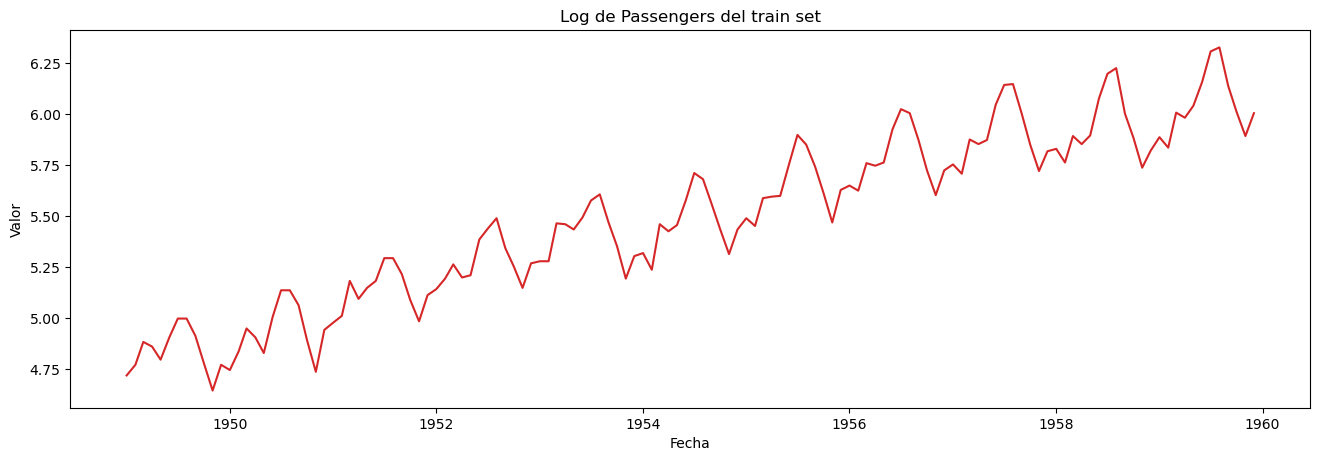

In [20]:
plot_df(df_train, x=df_train.Date, y=df_train['log_Passengers'],\
    title='Log de Passengers del train set')

Vemos que la dispersión de la serie se estabilizó significativamente en t. 

Ahora entrená un modelo lineal entre la serie transformada y la dummy de tiempo y analizá el summary.

In [21]:
model_log = smf.ols('log_Passengers ~ timeIndex',\
                          data = df_train).fit()

In [22]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_Passengers   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     1079.
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           8.28e-65
Time:                        15:10:53   Log-Likelihood:                 76.083
No. Observations:                 132   AIC:                            -148.2
Df Residuals:                     130   BIC:                            -142.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8132      0.024    202.952      0.000       4.766       4.860
timeIndex      0.0103      0.000     32.847      0.000       0.010       0.011
==============================================================================
Omnibus:                        3.395   Durbin-Watson:                   0.604
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                2.324
Skew:                           0.138   Prob(JB):                        0.313
Kurtosis:                       2.411   Cond. No.                         151.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Agregá las predicciones del modelo en el set de entrenamiento y de testeo con y sin back-transformation:

In [23]:
df_train['model_log'] = model_log.predict(df_train[["timeIndex"]])
df_test['model_log'] = model_log.predict(df_test[["timeIndex"]])

In [24]:
df_train['back_model_log'] = np.exp(df_train['model_log'])
df_test['back_model_log'] = np.exp(df_test['model_log'])

Ploteá las predicciones vs. las series reales, tanto en el set de entrenamiento como en el de testeo.

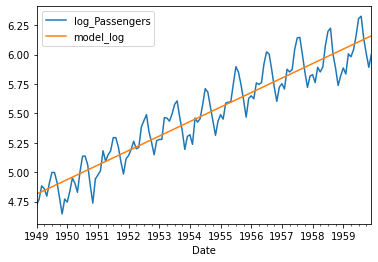

In [25]:
df_train.plot(kind = "line", x = "Date", y = ['log_Passengers', 'model_log']);

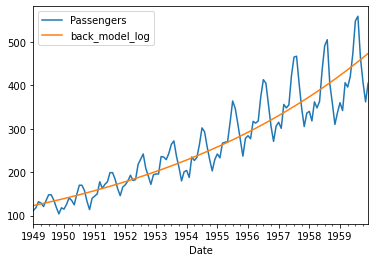

In [26]:
df_train.plot(kind = "line", x = "Date", y = ['Passengers', 'back_model_log']);

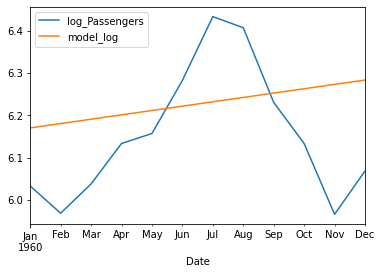

In [27]:
df_test.plot(kind = "line", x = "Date", y = ['log_Passengers', 'model_log']);

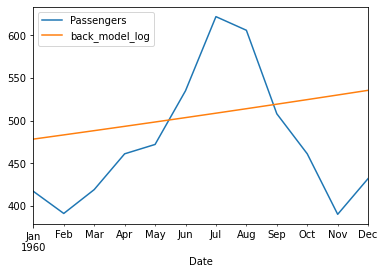

In [28]:
df_test.plot(kind = "line", x = "Date", y = ['Passengers', 'back_model_log']);

Creamos la función para calcular el RMSE:

In [29]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

Guardá el resultado en un DataFrame:

In [30]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Log"
df_Results.loc[0, "RMSE"] = RMSE(df_test.back_model_log, df_test.Passengers)
df_Results

,Model,RMSE
0,Log,79.3667


Ahora entrená un modelo agregando variables de estacionalidad mensual y agregá el RMSE en el DataFrame de resultados. 

In [31]:
model_log_est = smf.ols('log_Passengers ~ timeIndex + Month_3 + Month_4 + Month_5 + Month_6 + Month_7 + Month_8 + Month_9 + Month_11',\
                          data = df_train).fit()


In [32]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_Passengers   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     760.9
Date:                Tue, 27 Jul 2021   Prob (F-statistic):          1.10e-102
Time:                        15:10:54   Log-Likelihood:                 195.90
No. Observations:                 132   AIC:                            -371.8
Df Residuals:                     122   BIC:                            -343.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7180      0.012    389.739      0.000       4.694       4.742
timeIndex      0.0103      0.000     78.960      0.000       0.010       0.011
Month_3        0.1265      0.019      6.574      0.000       0.088       0.165
Month_4        0.0844      0.019      4.386      0.000       0.046       0.122
Month_5        0.0803      0.019      4.175      0.000       0.042       0.118
Month_6        0.2029      0.019     10.546      0.000       0.165       0.241
Month_7        0.3032      0.019     15.764      0.000       0.265       0.341
Month_8        0.2961      0.019     15.394      0.000       0.258       0.334
Month_9        0.1551      0.019      8.060      0.000       0.117       0.193
Month_11      -0.1271      0.019     -6.602      0.000      -0.165      -0.089
==============================================================================
Omnibus:                        3.602   Durbin-Watson:                   0.446
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                3.126
Skew:                          -0.283   Prob(JB):                        0.209
Kurtosis:                       2.502   Cond. No.                         468.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Comentario: recordá que podés usar el método precict del modelo para realizar predicciones.
Al método le tenés que pasar el DataFrame y especificar las columnas a incluir. 

Hacé las predicciones en el set de entrenamiento y testo y almacená los resultados en ambos DataFrames:

In [33]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex",\
                                              "Month_3", "Month_4", "Month_5", "Month_6",\
                                               "Month_7","Month_8", "Month_9", "Month_11"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex",\
                                              "Month_3", "Month_4", "Month_5", "Month_6",\
                                               "Month_7","Month_8", "Month_9", "Month_11"]])

Comentario: recordá que para hacer back transformation de una transformación logarítmica tenés que usar la función exponencial. 

Almacená en tus DataFrames los modelos con back transformation. 

In [34]:
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

Plotea el modelo con y sin back transformation para el set de entrenamiento:

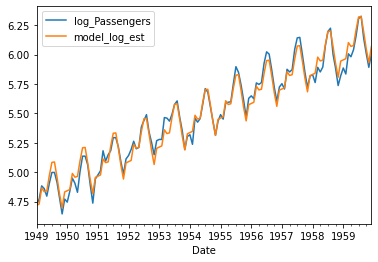

In [35]:
df_train.plot(kind = "line", x = "Date", y = ['log_Passengers', 'model_log_est']);

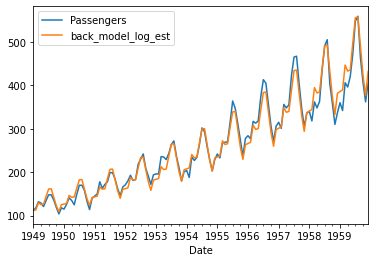

In [36]:
df_train.plot(kind = "line", x = "Date", y = ['Passengers', 'back_model_log_est']);

Plotea el modelo con y sin back transformation para el set de testeo:

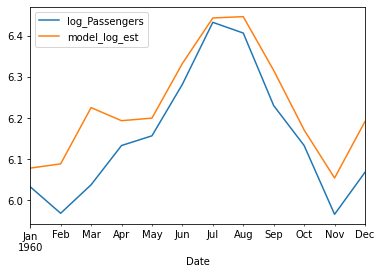

In [37]:
df_test.plot(kind = "line", x = "Date", y = ['log_Passengers', 'model_log_est']);

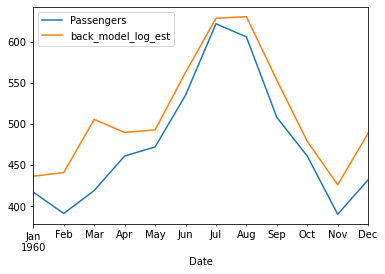

In [38]:
df_test.plot(kind = "line", x = "Date", y = ['Passengers', 'back_model_log_est']);

Calculá el RMSE del modelo con transformación logarítmica y estacionalidad mensual y agregala al DataFrame de resultados: 

In [39]:
df_Results.loc[0, "Model"] = "Log + Est"
df_Results.loc[0, "RMSE"] = RMSE(df_test.back_model_log_est, df_test.Passengers)
df_Results

,Model,RMSE
0,Log + Est,40.7441


### ARIMA

---
A partir de ahora vamos a trabajar para generar un modelo ARIMA.

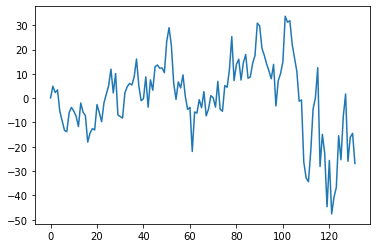

In [40]:
residuo = df_train['Passengers'] - df_train['back_model_log_est']

plt.plot(df_train.timeIndex, residuo, '-');

In [41]:
result = adfuller(residuo)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -2.363069
p-value: 0.152432
Valor crítico 1%: -3.49
Valor crítico 5%: -2.89
Valor crítico 10%: -2.58


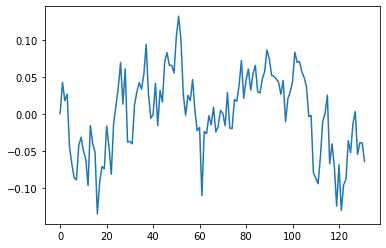

In [42]:
residuo_log = df_train['log_Passengers'] - df_train['model_log_est']

plt.plot(df_train.timeIndex, residuo_log, '-');

In [43]:
result = adfuller(residuo_log)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -3.078171
p-value: 0.028211
Valor crítico 1%: -3.48
Valor crítico 5%: -2.88
Valor crítico 10%: -2.58


In [44]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

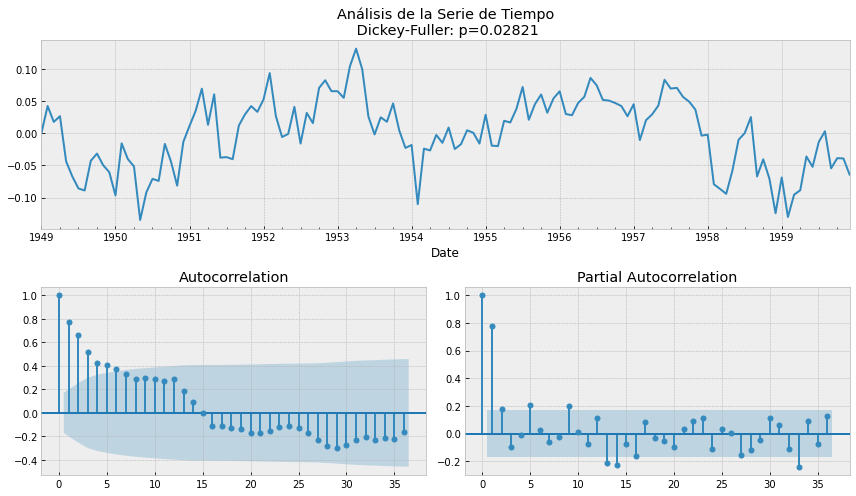

In [45]:
tsplot(residuo_log, lags=36)

Corré un modelo ARIMA(p,d,q) según los resultados del gráfico. ¿Cuáles van a ser los valores de p, d y q?

In [46]:
model_ARIMA = ARIMA(residuo_log, order=(1,0,4))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

Date
1949-01   -0.003811
1949-02   -0.000449
1949-03    0.027191
1949-04    0.021626
1949-05    0.015870
Freq: M, dtype: float64

Ahora analizá los resultados del modelo ploteando el summary:

In [47]:
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  132
Model:                     ARMA(1, 4)   Log Likelihood                 261.741
Method:                       css-mle   S.D. of innovations              0.033
Date:                Tue, 27 Jul 2021   AIC                           -509.483
Time:                        15:10:55   BIC                           -489.303
Sample:                    01-31-1949   HQIC                          -501.283
                         - 12-31-1959                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.018     -0.216      0.829      -0.038       0.031
ar.L1.y        0.9213      0.058     15.989      0.000       0.808       1.034
ma.L1.y       -0.2509      0.105     -2.385      0.0

Hacé un gráfico del residuo y del modelo ARIMA:

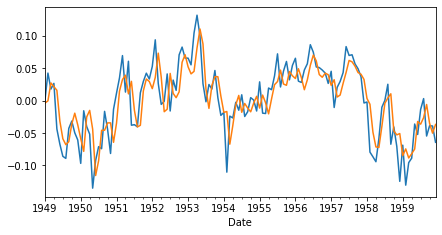

In [48]:
plt.figure(figsize=(7,3.5))
residuo_log.plot()
results_ARIMA.fittedvalues.plot();

Usá el método plot_predict() para hacer un gráfico 

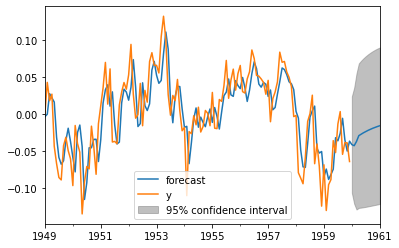

In [49]:
results_ARIMA.plot_predict(end=len(df['Passengers']));

Ahora calculá el residuo de nuestro modelo ARIMA y generá los gráficos que analizan la serie de tiempo. 

In [50]:
res_ARIMA =  results_ARIMA.fittedvalues - residuo_log

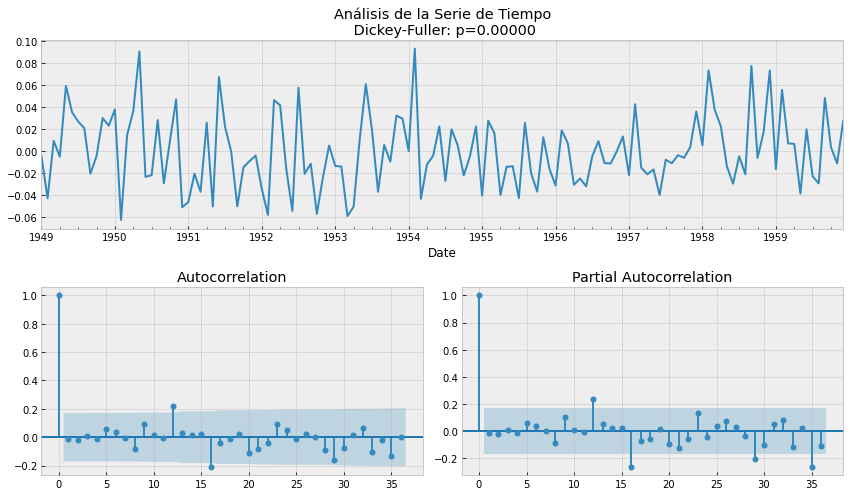

In [51]:
tsplot(res_ARIMA, lags=36)

Crea las predicciiones en el set de testeo con el método .forecast() del modelo estimado:

In [52]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test['Passengers']), alpha=0.05)

In [53]:
df_train['log_model_ARIMA'] = df_train['model_log_est'] + results_ARIMA.fittedvalues

df_test['log_model_ARIMA'] = df_test['model_log_est'] + predictions_ARIMA

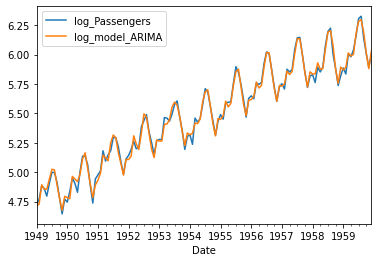

In [54]:
df_train.plot(kind = "line", y = ['log_Passengers', 'log_model_ARIMA']);

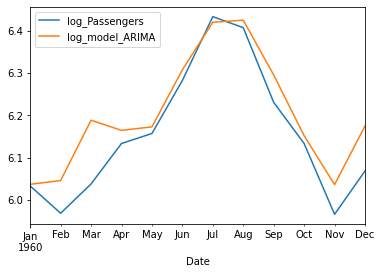

In [55]:
df_test.plot(kind = "line", y = ['log_Passengers', 'log_model_ARIMA']);

In [56]:
df_train['back_log_model_ARIMA'] = np.exp(df_train['log_model_ARIMA'])

df_test['back_log_model_ARIMA'] = np.exp(df_test['log_model_ARIMA'])

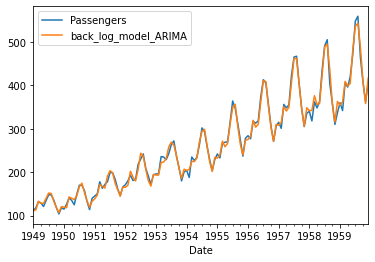

In [57]:
df_train.plot(kind = "line", y = ['Passengers', 'back_log_model_ARIMA']);

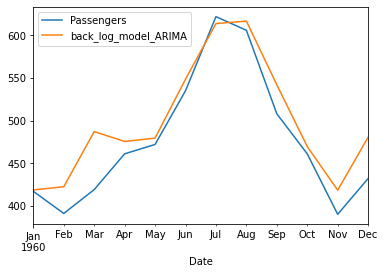

In [58]:
df_test.plot(kind = "line", y = ['Passengers', 'back_log_model_ARIMA']);

In [59]:
df_Results.loc[2, "Model"] = "Log Model + est + ARIMA"
df_Results.loc[2, "RMSE"] = RMSE(df_test['back_log_model_ARIMA'], df_test['Passengers'])
df_Results

,Model,RMSE
0,Log + Est,40.7441
2,Log Model + est + ARIMA,29.7652
